In [1]:
import torch
import torchvision
from torch import nn

import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## Load Dataset

In [3]:
## Load DataSet

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((28,28)),
        torchvision.transforms.ToTensor()
     ])

batch_size = 1000

trainset = torchvision.datasets.MNIST(root='L:/Datasets', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2)

torch.Size([1000, 1, 28, 28])


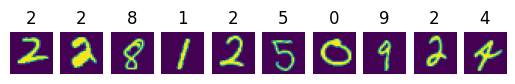

In [4]:
## View Img
def showBatchImg(images,labels,maxNum=5):
    fig, axes = plt.subplots(1, maxNum)
    for i in range(min(maxNum,images.shape[0])):
        axes[i].imshow(images[i].squeeze())
        axes[i].set_title(labels[i].item())
        axes[i].axis('off')

images, labels = next(iter(trainloader))
showBatchImg(images, labels, 10)
print(images.shape)

## GAN Model

Generator:  [noise] ==> Fake_Img  

Discriminator:  [Img] ==> Fake/Real

Loss: BCE(Fake/Real)


In [5]:
## Model
noiseShape = (64,3,3)
class Generator_Net(nn.Module):
    def __init__(self):              
        super().__init__()
        self.Generator = nn.Sequential(           ## B*64*3*3  (B*C *H*W)
            ##  in_channel,out_channel,kernel_size
            nn.ConvTranspose2d(64,32,6,stride=2),          ## ==> B*32* 10*10      H = (H-1)*strides + kernel_size
            nn.ConvTranspose2d(32,8,(6,6), stride=(2, 2)), ## ==> B*8*  24*24
            nn.ConvTranspose2d(8,1,5,stride=1),            ## ==> B*1*  28*28
        )
    def forward(self,noise):
        return self.Generator(noise)

class Discriminator_Net(nn.Module):
    def __init__(self):              
        super().__init__()
        self.Discriminator = nn.Sequential(
            nn.Conv2d(1,6,(5,5)),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(6,16,(5,5)),
            nn.Flatten(),
            nn.Linear(16*8*8,128),
            nn.LeakyReLU(),
            nn.Linear(128,1), 
            nn.Sigmoid(),
        )
    def forward(self,x):
        return self.Discriminator(x)

modelG = Generator_Net().to(device)
print(modelG)
modelD = Discriminator_Net().to(device)
print(modelD)

Generator_Net(
  (Generator): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
    (1): ConvTranspose2d(32, 8, kernel_size=(6, 6), stride=(2, 2))
    (2): ConvTranspose2d(8, 1, kernel_size=(5, 5), stride=(1, 1))
  )
)
Discriminator_Net(
  (Discriminator): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=1024, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [6]:
optimizer = torch.optim.SGD([{'params':modelG.parameters()},{'params':modelD.parameters()}], lr=1e-3)

def lossGfn(predF):
    return nn.BCELoss()(predF,torch.ones_like(predF))

def lossDfn(predF,predR):
    lossFake = nn.BCELoss()(predF,torch.zeros_like(predF))
    lossReal = nn.BCELoss()(predR,torch.ones_like(predR))
    return lossFake+lossReal

def train(dataloader, modelG, modelD, lossGfn, lossDfn, optimizer, D_Train=True):
    lossSumG = 0
    lossSumD = 0
    modelG.train()                                    
    modelD.train() 
    for batch, (RealImgs, y) in enumerate(dataloader):
        RealImgs = RealImgs.to(device)
        ## Gen Fake Img
        noise = torch.rand(batch_size, 64,3,3) 
        FakeImgs = modelG(noise)
        # Compute prediction error
        predF = modelD(FakeImgs)
        predR = modelD(RealImgs)
        lossG = lossGfn(predF)
        lossD = lossDfn(predF,predR)
        # Backpropagation
        optimizer.zero_grad()
        lossG.backward(retain_graph=True)
        if D_Train:
            lossD.backward()
        optimizer.step()
        ## Collect loss
        lossSumG += lossG
        lossSumD += lossD
    return lossG.item(),lossD.item()

In [7]:
for epoch in range(10):
    lossG,lossD = train(trainloader, modelG, modelD, lossGfn, lossDfn, optimizer, D_Train=True)
    lossG,lossD = train(trainloader, modelG, modelD, lossGfn, lossDfn, optimizer, D_Train=False)
    print(f'Epoch {epoch+1}----Generator Loss:: {lossG:>7f}----Discriminator Loss:: {lossD:>7f}')

Epoch 1----Generator Loss:: 0.555270----Discriminator Loss:: 1.403394
Epoch 2----Generator Loss:: 0.379227----Discriminator Loss:: 1.526790
Epoch 3----Generator Loss:: 0.246134----Discriminator Loss:: 1.760057
Epoch 4----Generator Loss:: 0.216554----Discriminator Loss:: 1.818153
Epoch 5----Generator Loss:: 0.212375----Discriminator Loss:: 1.796578
Epoch 6----Generator Loss:: 0.206305----Discriminator Loss:: 1.786662
Epoch 7----Generator Loss:: 0.182529----Discriminator Loss:: 1.860641
Epoch 8----Generator Loss:: 0.144373----Discriminator Loss:: 2.048465
Epoch 9----Generator Loss:: 0.115243----Discriminator Loss:: 2.244666
Epoch 10----Generator Loss:: 0.096540----Discriminator Loss:: 2.404921


torch.Size([10, 1, 28, 28])


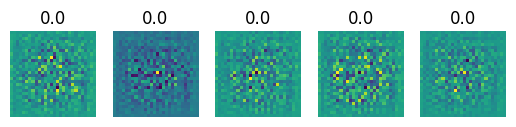

In [8]:
## Use Prediction
modelG.eval()
noise = torch.rand(10, 64,3,3)  ## B*noiseShape 
FakeImgs = modelG(noise)
print(FakeImgs.shape)
showBatchImg(FakeImgs.detach(), np.zeros(FakeImgs.shape[0]))